In [1]:
## Relevant modules.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Reading file.
file = 'data/data_panel.csv'
panel = pd.read_csv(file, header=0)
print(panel.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8294 entries, 0 to 8293
Data columns (total 12 columns):
doc_code       8294 non-null int64
spec_code      8294 non-null int64
spec_es        8294 non-null object
spec_en        8294 non-null object
year           8294 non-null int64
n_visits       8294 non-null int64
n_surgeries    8294 non-null int64
n_patients     8294 non-null int64
c_visit        8288 non-null float64
c_surgery      8292 non-null float64
dep_code       8294 non-null int64
department     8294 non-null object
dtypes: float64(2), int64(7), object(3)
memory usage: 777.6+ KB
None


In [3]:
group_1 = panel.groupby(['spec_code','dep_code','year'])[['doc_code']].count()
group_1.rename(columns={'doc_code': 'doc_count'}, inplace=True)
group_1 = group_1[group_1['doc_count'] > 30].reset_index()

group_2 = group_1.groupby(['spec_code','dep_code'])[['year']].count()
group_2.rename(columns={'year': 'year_count'}, inplace=True)
group_2 = group_2[group_2['year_count'] == 5].reset_index()

group_3 = group_2.groupby(['spec_code'])[['dep_code']].count()
group_3.rename(columns={'dep_code': 'dep_count'}, inplace=True)
group_3 = group_3[group_3['dep_count'] > 1].reset_index()

merge_3_2 = pd.merge(group_3, group_2, on=['spec_code'])
merge_3_2_1 = pd.merge(merge_3_2, group_1, on=['spec_code','dep_code'])

group = merge_3_2_1.drop(['year_count','dep_count'], axis=1)
print(group.set_index(['spec_code','dep_code','year']))
print('Total doc observations:', group['doc_count'].sum())

                         doc_count
spec_code dep_code year           
200       5        2008         74
                   2009         69
                   2010         69
                   2011         72
                   2012         64
          76       2008         34
                   2009         38
                   2010         38
                   2011         39
                   2012         42
341       5        2008        100
                   2009         98
                   2010        101
                   2011         95
                   2012         94
          76       2008         52
                   2009         44
                   2010         47
                   2011         50
                   2012         51
480       5        2008        118
                   2009        115
                   2010        109
                   2011        115
                   2012        104
          76       2008         35
                   2

In [4]:
subpanel = pd.merge(panel, group, on=['spec_code','dep_code','year'])
subpanel.drop('doc_count', axis=1, inplace=True)
subpanel['surgeries2visits']=subpanel['n_surgeries']/subpanel['n_visits']
print(subpanel.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 0 to 2551
Data columns (total 13 columns):
doc_code            2552 non-null int64
spec_code           2552 non-null int64
spec_es             2552 non-null object
spec_en             2552 non-null object
year                2552 non-null int64
n_visits            2552 non-null int64
n_surgeries         2552 non-null int64
n_patients          2552 non-null int64
c_visit             2552 non-null float64
c_surgery           2552 non-null float64
dep_code            2552 non-null int64
department          2552 non-null object
surgeries2visits    2552 non-null float64
dtypes: float64(3), int64(7), object(3)
memory usage: 279.1+ KB
None


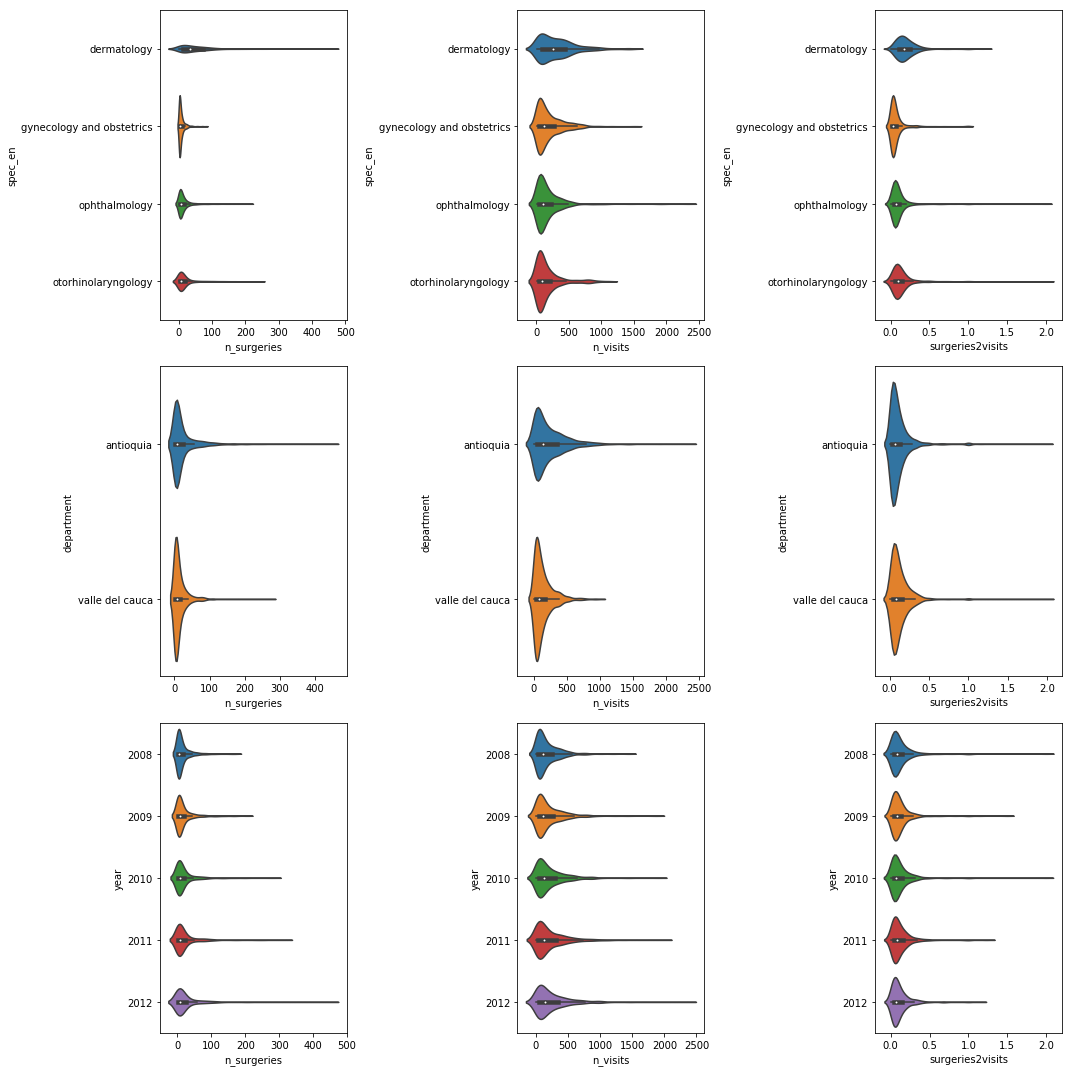

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for i in [['spec_en',0],['department',1],['year',2]]:
    _ = sns.catplot(x='n_surgeries', y=i[0], data=subpanel, 
                    orient='h', kind='violin', ax=ax[i[1],0])
    plt.close()
    _ = sns.catplot(x='n_visits', y=i[0], data=subpanel, 
                    orient='h', kind='violin', ax=ax[i[1],1])
    plt.close()
    _ = sns.catplot(x='surgeries2visits', y=i[0], data=subpanel,
                    orient='h', kind='violin', ax=ax[i[1], 2])
    plt.close()
plt.tight_layout()
plt.show()

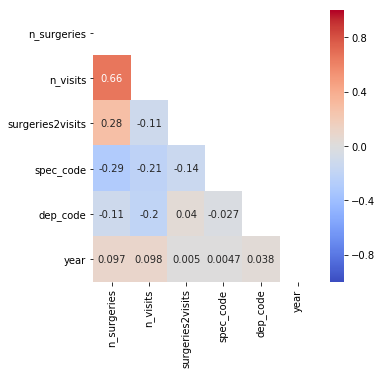

In [6]:
subset = subpanel[['n_surgeries','n_visits','surgeries2visits',
                   'spec_code','dep_code','year']]
subset_corr = subset.corr()

mask = np.zeros_like(subset_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(5,5))
_ = sns.heatmap(subset_corr, vmin=-1, cmap='coolwarm',
                annot=True, mask = mask)

In [7]:
def bootstrap_replicate_1d(data, func): 
    return func(np.random.choice(data, len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

def bs_95_ci(data, func, size=1):
    return np.percentile(draw_bs_reps(data, func, size), [2.5, 97.5])

In [8]:
np.random.seed(10)
print('Mean of number of surgeries:\n')

for i in np.unique(subpanel['spec_en']):
    data = subpanel['n_surgeries'][subpanel['spec_en']==i]
    ci_surgeries_spec = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_surgeries_spec)
print()
for i in np.unique(subpanel['department']):
    data = subpanel['n_surgeries'][subpanel['department']==i]
    ci_surgeries_dep = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_surgeries_dep)
print()
for i in np.unique(subpanel['year']):
    data = subpanel['n_surgeries'][subpanel['year']==i]
    ci_surgeries_year = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_surgeries_year)

Mean of number of surgeries:

95% c. i. if dermatology = [46.4359462 56.0987013]
95% c. i. if gynecology and obstetrics = [6.36471995 7.68852459]
95% c. i. if ophthalmology = [11.85241514 14.79252611]
95% c. i. if otorhinolaryngology = [16.165      21.77286408]

95% c. i. if antioquia = [21.51713205 25.4229203 ]
95% c. i. if valle del cauca = [13.07560024 16.50183073]

95% c. i. if 2008 = [13.52718872 17.77242218]
95% c. i. if 2009 = [15.83987154 20.91699605]
95% c. i. if 2010 = [17.52077535 23.81515905]
95% c. i. if 2011 = [19.33460803 26.19698853]
95% c. i. if 2012 = [22.00197628 30.24733202]


In [9]:
np.random.seed(10)
print('Mean of number of visits:\n')

for i in np.unique(subpanel['spec_en']):
    data = subpanel['n_visits'][subpanel['spec_en']==i]
    ci_visits_spec = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_visits_spec)
print()
for i in np.unique(subpanel['department']):
    data = subpanel['n_visits'][subpanel['department']==i]
    ci_visits_dep = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_visits_dep)
print()
for i in np.unique(subpanel['year']):
    data = subpanel['n_visits'][subpanel['year']==i]
    ci_visits_year = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_visits_year)

Mean of number of visits:

95% c. i. if dermatology = [285.06447124 333.0744898 ]
95% c. i. if gynecology and obstetrics = [175.03773907 203.88951503]
95% c. i. if ophthalmology = [156.33012402 187.62800261]
95% c. i. if otorhinolaryngology = [146.40951456 182.9742233 ]

95% c. i. if antioquia = [224.6022833  249.26179465]
95% c. i. if valle del cauca = [126.75030012 147.14447779]

95% c. i. if 2008 = [152.73122568 184.84654669]
95% c. i. if 2009 = [172.87336957 210.81462451]
95% c. i. if 2010 = [187.91237575 229.36053678]
95% c. i. if 2011 = [193.61338432 236.81075526]
95% c. i. if 2012 = [214.73305336 262.86086957]


In [10]:
np.random.seed(10)
print('Mean of surgeries-to-visits ratio:\n')

for i in np.unique(subpanel['spec_en']):
    data = subpanel['surgeries2visits'][subpanel['spec_en']==i]
    ci_surgeries2visits_spec = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_surgeries2visits_spec)
print()
for i in np.unique(subpanel['department']):
    data = subpanel['surgeries2visits'][subpanel['department']==i]
    ci_surgeries2visits_dep = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_surgeries2visits_dep)
print()
for i in np.unique(subpanel['year']):
    data = subpanel['surgeries2visits'][subpanel['year']==i]
    ci_surgeries2visits_year = bs_95_ci(data, np.mean, size=10000)
    print('95% c. i. if',i,'=',ci_surgeries2visits_year)

Mean of surgeries-to-visits ratio:

95% c. i. if dermatology = [0.18837255 0.21554104]
95% c. i. if gynecology and obstetrics = [0.06123718 0.07769635]
95% c. i. if ophthalmology = [0.09275932 0.1127296 ]
95% c. i. if otorhinolaryngology = [0.12524709 0.15436289]

95% c. i. if antioquia = [0.10992058 0.12412075]
95% c. i. if valle del cauca = [0.11999522 0.14085257]

95% c. i. if 2008 = [0.10952586 0.13801082]
95% c. i. if 2009 = [0.10388632 0.12896898]
95% c. i. if 2010 = [0.10641497 0.1334478 ]
95% c. i. if 2011 = [0.11404934 0.14059245]
95% c. i. if 2012 = [0.10815701 0.13319427]


Conclusions:

Specialty definetly changes the mean of surgeries, not necessarialy the mean of visits. It definetly changes the mean of surgeries-to-visits ratio. 

Department definetly changes the mean of surgeries and the mean of visits. It doesn't necessarialy change the mean of surgeries-to-visits ratio. 

Year definetly changes the mean of surgeries and the mean of visits in the long run, if you compare 2008 to 2012 for example. As time pass, both measurements tend to increase. However, because of that, year does not change the the mean of surgeries-to-visits ratio.